<a href="https://colab.research.google.com/github/hrumst/ML/blob/master/Competition_self_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%config IPComplater.greedy = True

In [0]:
from google.colab import drive

DRIVE_MOUNT = './DRIVE/'
DRIVE_MOUNT_SAVE_MODEL_PATH = 'My Drive/Colab Notebooks/competition_7/brand-logo-detection-dataset.zip'
drive.mount(DRIVE_MOUNT, force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./DRIVE/


In [0]:
!rm -rf input \
&& mkdir input \
&& unzip "./DRIVE/My Drive/competition_7/brand-logo-detection-dataset.zip" -d input

Archive:  ./DRIVE/My Drive/competition_7/brand-logo-detection-dataset.zip
   creating: input/brand-logo-detection-dataset/
   creating: input/brand-logo-detection-dataset/trainval_jpg/
  inflating: input/brand-logo-detection-dataset/trainval_jpg/4652863706.jpg  
   creating: input/__MACOSX/
   creating: input/__MACOSX/brand-logo-detection-dataset/
   creating: input/__MACOSX/brand-logo-detection-dataset/trainval_jpg/
  inflating: input/__MACOSX/brand-logo-detection-dataset/trainval_jpg/._4652863706.jpg  
  inflating: input/brand-logo-detection-dataset/trainval_jpg/4328758763.jpg  
  inflating: input/__MACOSX/brand-logo-detection-dataset/trainval_jpg/._4328758763.jpg  
  inflating: input/brand-logo-detection-dataset/trainval_jpg/320927855.jpg  
  inflating: input/__MACOSX/brand-logo-detection-dataset/trainval_jpg/._320927855.jpg  
  inflating: input/brand-logo-detection-dataset/trainval_jpg/2653776560.jpg  
  inflating: input/__MACOSX/brand-logo-detection-dataset/trainval_jpg/._26537765

In [0]:
import sys
import os

ROOT_DIR = DRIVE_MOUNT + 'My Drive/colab_data/Mask_RCNN-master'
print(ROOT_DIR)
sys.path.insert(0, ROOT_DIR)
sys.path.insert(0, ROOT_DIR + '/mrcnn')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

./DRIVE/My Drive/colab_data/Mask_RCNN-master


In [0]:
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [0]:
import pandas as pd

BASE_DATA_DIR = 'input/brand-logo-detection-dataset/'
df = pd.read_csv(BASE_DATA_DIR + 'trainval_bboxes.txt', header=None)
df.columns = ['image_id','brand_name','x', 'y', 'width', 'height']
df.head()

,image_id,brand_name,x,y,width,height
0,2325670467.jpg,google,51,198,892,342
1,2359495755.jpg,google,73,228,948,327
2,2727802511.jpg,google,68,72,854,311
3,321106127.jpg,google,461,354,519,203
4,343855903.jpg,google,176,104,686,413


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2

IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256

In [0]:
def split_datasets(val=.1, dataset):
    val_dataset = []
    train_dataset = []
    for item in dataset:
        if np.random.rand() <= val:
            val_dataset.append(item)
        else:
            train_dataset.append(item)
    return (train_dataset, val_dataset)


In [0]:
print(len(df['brand_name'].unique()))
print(df['brand_name'].unique())
# print(df.groupby('brand_name').agg({'image_id':'count'}))
# print(df.groupby('image_id').agg({'brand_name': 'count'}))


for image_id in df['image_id'].unique():
    image_data = df[df['image_id'] == image_id]
    for (i, row) in image_data.iterrows():

In [0]:


class BrandsDataset(utils.Dataset):
    def load_data(self, brands, images):
        brand_dict = dict()
        for (i, brand) in enumerate(brands):
            self.add_class('brands', i, brand)
            brand_dict[brand] = i

        for (i, image_id) in enumerate(df['image_id'].unique()):
            image_data = df[df['image_id'] == image_id]
            brands = []
            for (i, row) in image_data.iterrows():
                brand_info = dict(
                    brand_id = brand_dict[row['brand_name']],
                    x = row['x'],
                    y = row['y'],
                    width = row['width'],
                    height = row['height'],
                )
                brands.append(brand_info)
            self.add_image(
                'brands', 
                image_id=image_id, 
                path=BASE_DATA_DIR + 'trainval_jpg/' + row['image_id'], 
                brands=brands,
            ) 

    def load_image(self, image_id):
        image_info = self.image_info[image_id]
        image = cv2.imread(image_info['path'])
        image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
        return image

    def load_mask(self, image_id):
        ## TODO move to load
        img = cv2.imread(path)
        img_width, img_heigth, channels = img.shape

        image_info = self.image_info[image_id]
        brand_ids = []
        masks = np.zeros([IMAGE_HEIGHT, IMAGE_WIDTH, len(image_info['brands'])], dtype=np.uint8)
        for (i, brand) in enumerate(image_info['brands']):
            mask = np.zeros([img_width, img_heigth, 1])
            mask[brand['y']:brand['y'] + brand['height'], brand['x']:brand['x'] + brand['width']] = 1
            mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))[..., np.newaxis]
            masks[:, :, i:i+1] = mask
            brand_ids.append(brand['brand_id'])

        return (masks.astype(np.bool), brand_ids)

val_dataset, train_dataset = split_datasets(df['image_id'].unique())

train_bds = BrandsDataset()
train_bds.load_data(df['brand_name'].unique(), train_dataset)
train_bds.prepare()

val_bds = BrandsDataset()
val_bds.load_data(df['brand_name'].unique(), val_dataset)
val_bds.prepare()

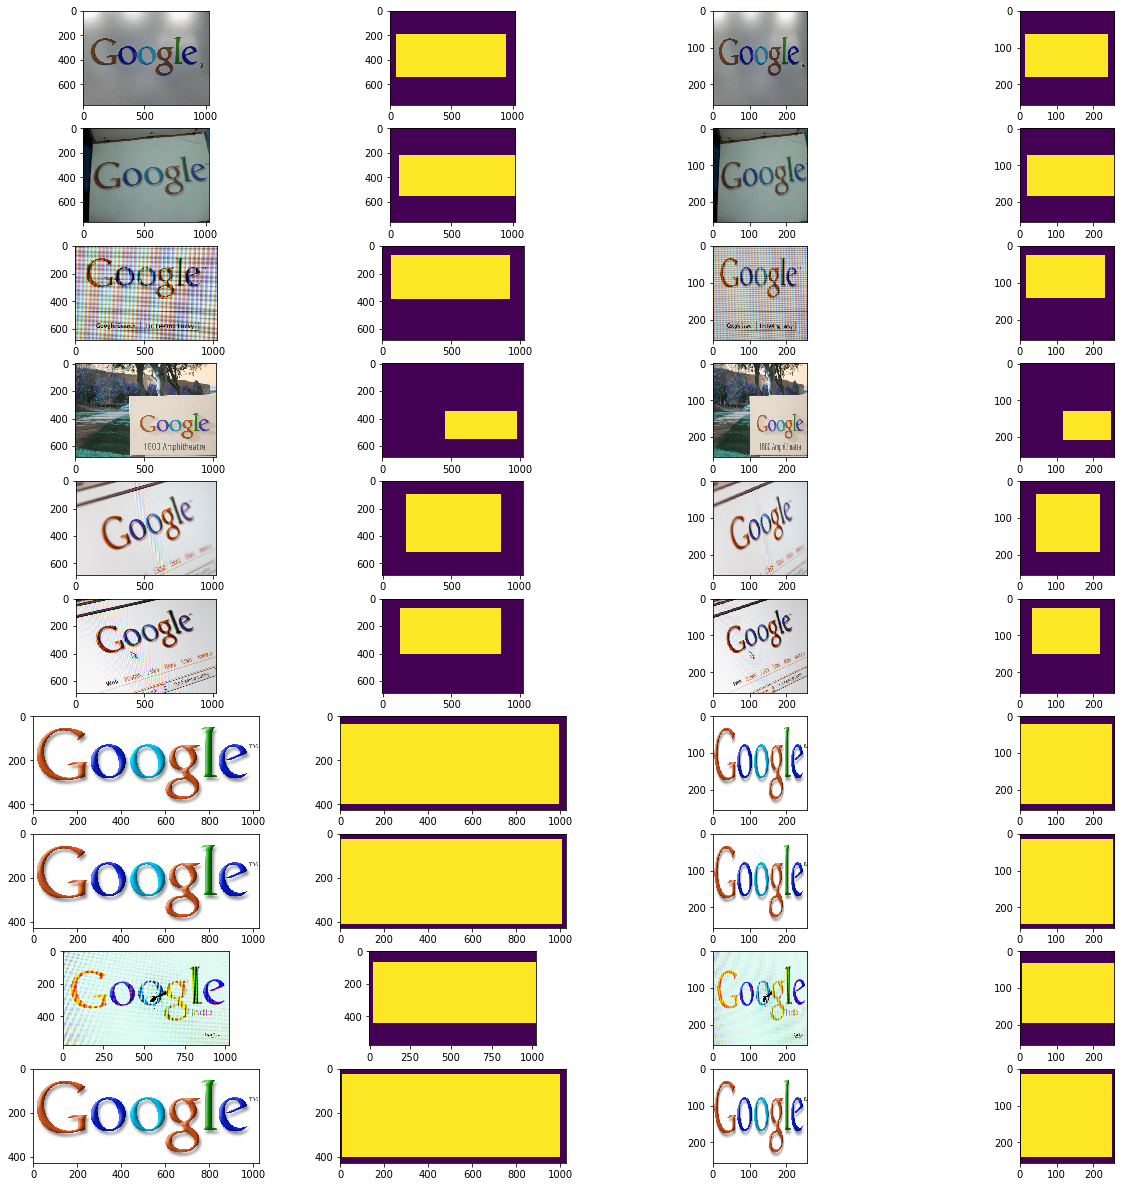

In [0]:
imag_ids = df['image_id'].unique()[:10]

fig = plt.figure(figsize=(24, 64)) 
gs = gridspec.GridSpec(10, 4 ,wspace=0.25, hspace=0.25, top=0.3, bottom=0.05, left=0.17, right=0.845) 

for (i, img_id) in enumerate(imag_ids):

    path = BASE_DATA_DIR + 'trainval_jpg/' + img_id
    img = cv2.imread(path)

    img_width, img_heigth, channels = img.shape

    image_data = df[df['image_id'] == img_id].iloc[0]
    mask = np.zeros((img_width, img_heigth))
    mask[image_data['y']:image_data['y'] + image_data['height'], image_data['x']:image_data['x'] + image_data['width']] = 1

    ax1 = plt.subplot(gs[i,0])
    ax2 = plt.subplot(gs[i,1])
    ax1.imshow(img)
    ax2.imshow(mask)

    image = train_bds.load_image(i)
    masks, brand_ids = train_bds.load_mask(i)
    mask = masks[:, :, 0]

    ax3 = plt.subplot(gs[i,2])
    ax4 = plt.subplot(gs[i,3])
    ax3.imshow(image)
    ax4.imshow(mask)


plt.pause(.01)

In [0]:
bds.__dict__.keys()

dict_keys(['_image_ids', 'image_info', 'class_info', 'source_class_ids'])

In [0]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [0]:
# Which weights to start with?
init_with = "imagenet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

In [0]:
model.train(train_bds, val_bds, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=5, 
            layers="all")

In [0]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [0]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [0]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())